# Exemplo de predição de preço de ações com LSTM 

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

## Preço das ações da Google

In [53]:
#download dataset 
link = 'https://query1.finance.yahoo.com/v7/finance/download/GOOG?period1=1325376000&period2=1577836800&interval=1d&events=history&includeAdjustedClose=true'
dataset = pd.read_csv(link)
dataset.head()
# o dataset possui 6 colunas

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
1,2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2,2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
3,2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
4,2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981


In [55]:
# separação do dataset em treino e teste
# 80% para treino e 20% para teste
treino = dataset.iloc[:int(dataset.shape[0]*0.8), 1:2].values
teste = dataset.iloc[int(dataset.shape[0]*0.8):, 1:2].values

# normalização dos dados
sc = MinMaxScaler(feature_range = (0, 1))
treino_normalizado = sc.fit_transform(treino)
teste_normalizado = sc.transform(teste)


In [63]:
# criação da estrutura de dados com 60 timestamps e 1 output. 
# o timestamp é o número de dias que a rede neural vai olhar para trás para fazer a previsão
# o output é o número de dias que a rede neural vai prever
X_treino = []
y_treino = []
for i in range(60, treino_normalizado.shape[0]):
    X_treino.append(treino_normalizado[i-60:i, 0])
    y_treino.append(treino_normalizado[i, 0])
X_treino, y_treino = np.array(X_treino), np.array(y_treino)

# reshape
X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))


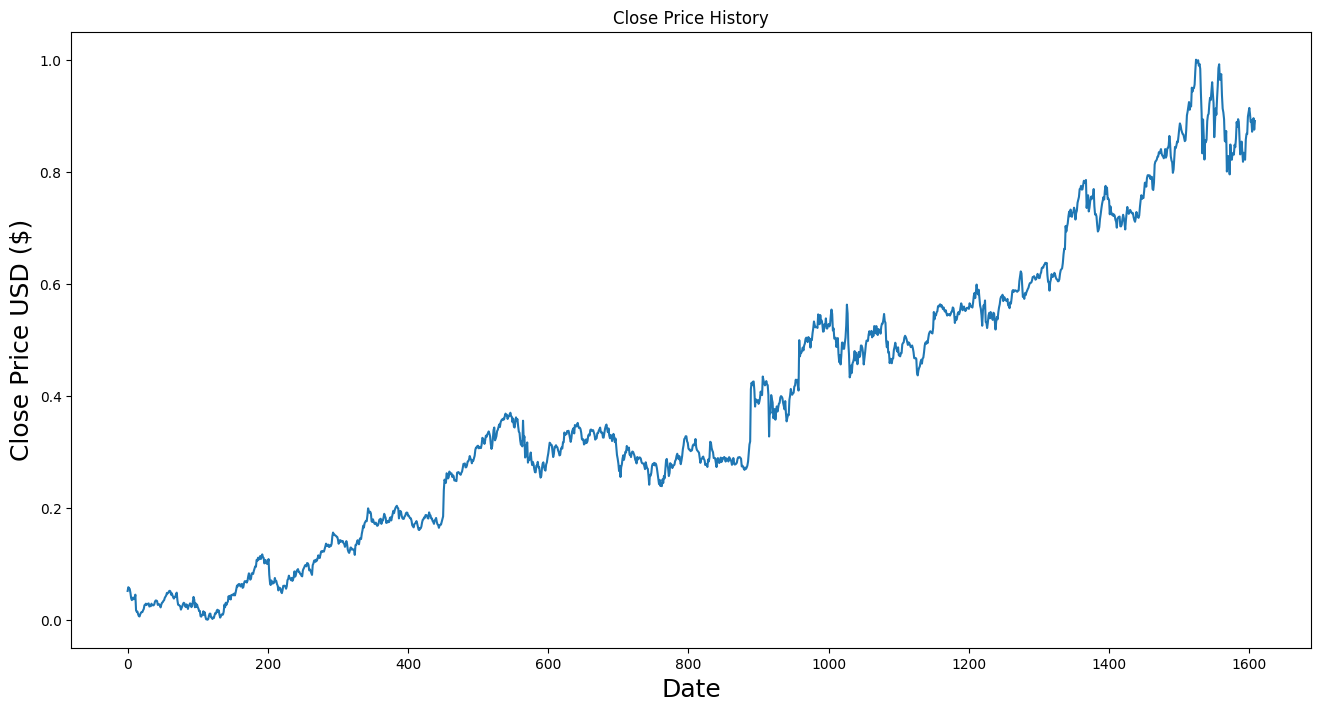

In [57]:
#plot do gráfico de treino
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(treino_normalizado)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


In [60]:
# criação da rede LSTM
regressor = Sequential()

# primeira camada LSTM e Dropout
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_treino.shape[1], 1)))
regressor.add(Dropout(0.2))

# segunda camada LSTM e Dropout
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# quarta camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# camada de saída
regressor.add(Dense(units = 1))

# compilação
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# treinamento
regressor.fit(X_treino, y_treino, epochs = 100, batch_size = 32)


Epoch 1/100
49/49 [==============================] - 34s 167ms/step - loss: 0.0191
Epoch 2/100
49/49 [==============================] - 7s 152ms/step - loss: 0.0033
Epoch 3/100
49/49 [==============================] - 7s 152ms/step - loss: 0.0031
Epoch 4/100
49/49 [==============================] - 8s 153ms/step - loss: 0.0031
Epoch 5/100
49/49 [==============================] - 7s 149ms/step - loss: 0.0031
Epoch 6/100
49/49 [==============================] - 7s 150ms/step - loss: 0.0032
Epoch 7/100
49/49 [==============================] - 7s 150ms/step - loss: 0.0026
Epoch 8/100
49/49 [==============================] - 7s 149ms/step - loss: 0.0026
Epoch 9/100
49/49 [==============================] - 8s 153ms/step - loss: 0.0027
Epoch 10/100
49/49 [==============================] - 7s 147ms/step - loss: 0.0026
Epoch 11/100
49/49 [==============================] - 7s 145ms/step - loss: 0.0029
Epoch 12/100
49/49 [==============================] - 7s 152ms/step - loss: 0.0024
Epoch 13/100

11/11 [==============================] - 9s 112ms/step


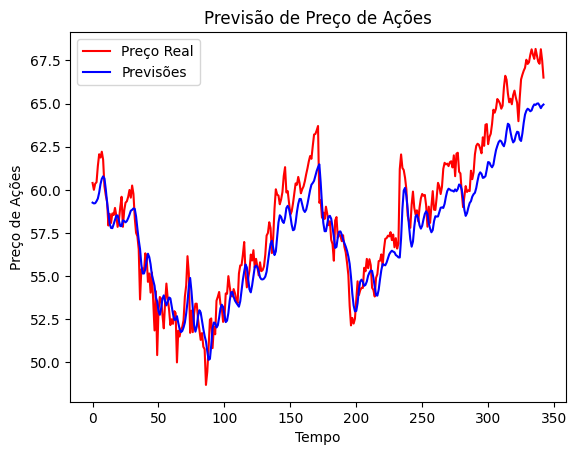

In [61]:
# criação da estrutura de dados com 60 timestamps e 1 output
X_teste = []
y_teste = []

for i in range(60, teste_normalizado.shape[0]):
    X_teste.append(teste_normalizado[i-60:i, 0])
    y_teste.append(teste_normalizado[i, 0])

X_teste, y_teste = np.array(X_teste), np.array(y_teste)

# reshape
# reshape
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

# previsões
previsoes = regressor.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

# visualização dos resultados
# visualização dos resultados
plt.plot(teste[60:], color = 'red', label = 'Preço Real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão de Preço de Ações')
plt.xlabel('Tempo')
plt.ylabel('Preço de Ações')
plt.legend()
plt.show()


26/26 [==============================] - 2s 85ms/step
[64.94388]


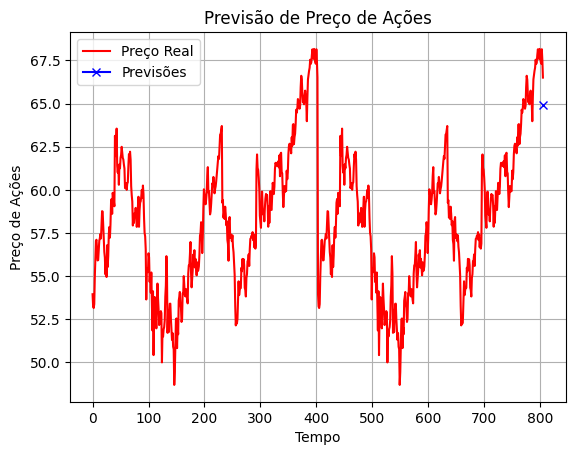

In [87]:
# fazendo uma previsão de 1 dia

# pegando o último dia do dataset de treino
ultimo_dia = dataset.iloc[int(dataset.shape[0]*0.8)-60:, 1:2].values

# concatenando o último dia do dataset de treino com o dataset de teste
ultimo_dia = np.concatenate((ultimo_dia, teste), axis = 0)

# normalizando o dataset
ultimo_dia_normalizado = sc.transform(ultimo_dia)

# criando a estrutura de dados com 60 timestamps e 1 output
X_ultimo_dia = []
for i in range(60, ultimo_dia_normalizado.shape[0]):
    X_ultimo_dia.append(ultimo_dia_normalizado[i-60:i, 0])
X_ultimo_dia = np.array(X_ultimo_dia)

# reshape
X_ultimo_dia = np.reshape(X_ultimo_dia, (X_ultimo_dia.shape[0], X_ultimo_dia.shape[1], 1))

# previsão do dia seguinte
previsao = regressor.predict(X_ultimo_dia)
previsao = sc.inverse_transform(previsao)

#print preço no dia n+1 (dia seguinte)
print(previsao[-1])

# plot do gráfico da serie mais n+1 predito pelo modelo
plt.plot(ultimo_dia[60:], color = 'red', label = 'Preço Real')
plt.plot(806,previsao[-1], color = 'blue', label = 'Previsões', marker='x')
plt.title('Previsão de Preço de Ações')
plt.xlabel('Tempo')
plt.ylabel('Preço de Ações')
plt.legend()
plt.grid()
plt.show()




C:\Users\rosan\AppData\Local\Temp\ipykernel_5928\2216958023.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  entradas = base_completa[len(base_completa) - len(teste) - 60:].values


1/1 [==============================] - 0s 160ms/step


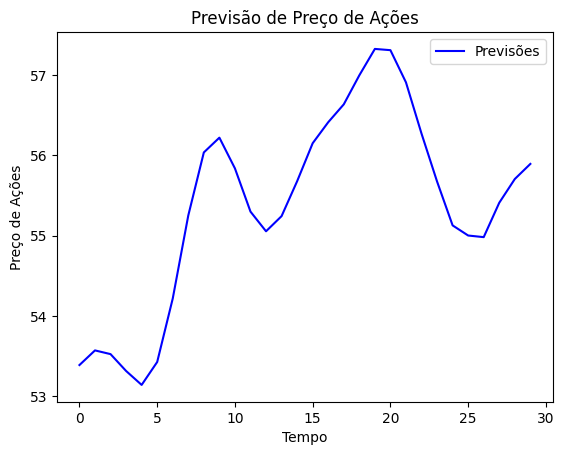

In [62]:
# previsões para os próximos 30 dias
base_completa = pd.concat((dataset['Open'], dataset['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(teste) - 60:].values
entradas = entradas.reshape(-1,1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(60, 90):
    X_teste.append(entradas[i-60:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = regressor.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

# visualização dos resultados
# visualização dos resultados
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão de Preço de Ações')
plt.xlabel('Tempo')
plt.ylabel('Preço de Ações')
plt.legend()
plt.show()
